# Spatial Analysis in Geology using R

## by Pedro Nogueira

<span style="color:red;"> 
    <h1> 13. Putting it all to work: Part II vectors </h1>
</span>

In [1]:
#13-00
# Settings


# Print the R version information
print(R.version)

# Verify thw working directory
wd_base = getwd()
print(wd_base)

               _                           
platform       aarch64-apple-darwin20      
arch           aarch64                     
os             darwin20                    
system         aarch64, darwin20           
status                                     
major          4                           
minor          3.1                         
year           2023                        
month          06                          
day            16                          
svn rev        84548                       
language       R                           
version.string R version 4.3.1 (2023-06-16)
nickname       Beagle Scouts               
[1] "/Users/pnogasmacmini/Documents/Jupyter Notebooks/SAGR/Part II"


<span style="color:green;"> 
    <h2> 13.1 Setting the data </h2>
</span>

In [3]:
#13-01
# Read the data
nt_ss = read.csv("../NT_SS/GEOCHEM_STREAM_SEDIMENTS.csv")

# Filter the dataset
company_name = grepl("^Bureau of Mineral", nt_ss$COMPANY)
query = nt_ss$COMPANY == company_name

# Create the subset
nt_ss_bmrgg = nt_ss[company_name,]

# Remove columns that are NA
na_cols = which(base::colSums(is.na(nt_ss_bmrgg)) == nrow(nt_ss_bmrgg))
print(paste(length(na_cols), "NA columns rejected"))

# Subset the data frame to exclude the all-NA columns
nt_ss_bmrgg_filtered = nt_ss_bmrgg[ , -na_cols]
print(paste(ncol(nt_ss_bmrgg_filtered),"columns present"))

# Remove -9999 columns
na_cols = which(colSums(nt_ss_bmrgg_filtered == -9999) ==
nrow(nt_ss_bmrgg_filtered ))

# Verify the results
print(paste(length(na_cols),"-9999 columns rejected"))

# Subset the data frame to exclude the all the NA columns
nt_ss_bmrgg_10 = nt_ss_bmrgg_filtered[ , -na_cols]

# Verify the results
print(paste(ncol(nt_ss_bmrgg_10),"columns present"))

# Replace all the -9999 remaining by NA
nt_ss_bmrgg_10[nt_ss_bmrgg_10 == -9999] = NA

# Verify the results
colnames(nt_ss_bmrgg_10)

# Create two datasets
bmrgg = nt_ss_bmrgg_10 # All the pre-processed data
bmrgg_chem = nt_ss_bmrgg_10[ ,c(3,21:38)] # The chemical analysis

[1] "2 NA columns rejected"
[1] "203 columns present"
[1] "165 -9999 columns rejected"
[1] "38 columns present"


[1] "UNIQ_ID"        "ID"             "SAMPLEID"       "SAMPLEREF"     
 [5] "SAMPLE_TYPE"    "SAMPLE_METHOD"  "LONGITUDE"      "LATITUDE"      
 [9] "LITHOLOGY"      "MINMESH"        "MAXMESH"        "COMPANY"       
[13] "ACCURACY"       "TITLE"          "MAP_SHEET_100K" "MAP_SHEET_250K"
[17] "REPORT_NO"      "OPEN_FILE"      "JOB_NO"         "COMMENTS"      
[21] "AG_PPM"         "AS_PPM"         "BA_PPM"         "BI_PPM"        
[25] "CO_PPM"         "CR_PPM"         "CU_PPM"         "FE_PCT"        
[29] "MN_PPM"         "MO_PPM"         "NI_PPM"         "PB_PPM"        
[33] "SN_PPM"         "TH_PPM"         "TI_PPM"         "U_PPM"         
[37] "W_PPM"          "ZN_PPM"

In [9]:
#13-02
# The necessary libraries
library(dplyr)
library(sp)
library(sf)
library(raster)
library(ggplot2)
library(ggspatial)
library(leaflet)

# Define the working folder
#setwd("NT_SS/")

# Create a bmrgg stream sediments data
bmrgg_sf = st_as_sf(bmrgg, coords = c("LONGITUDE","LATITUDE"), crs=4326)

In [10]:
#13-03
# Read the Geology and the Faults data
geo = st_read("/Users/pnogasmacmini/Documents/Jupyter Notebooks/SAGR/NT_SS/GEO_INTERP_2500K.shp")
faults = st_read("/Users/pnogasmacmini/Documents/Jupyter Notebooks/SAGR/NT_SS/GEO_FAULTS_2500K.shp")

# Convert to WGS84
geo = st_transform(geo, crs=4326)
faults = st_transform(faults, crs=4326)

# Create bbox()
geo_bb = st_bbox(bmrgg_sf)

# CROP Geology and Faults
geo_bmrgg = st_crop(geo, geo_bb) # Geology
flt_bmrgg = st_crop(faults, geo_bb) # Faults

Reading layer `GEO_INTERP_2500K' from data source 
  `/Users/pnogasmacmini/Documents/Jupyter Notebooks/SAGR/NT_SS/GEO_INTERP_2500K.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1975 features and 13 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 129 ymin: -26 xmax: 138 ymax: -10.83333
Geodetic CRS:  GDA94
Reading layer `GEO_FAULTS_2500K' from data source 
  `/Users/pnogasmacmini/Documents/Jupyter Notebooks/SAGR/NT_SS/GEO_FAULTS_2500K.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 849 features and 5 fields
Geometry type: MULTILINESTRING
Dimension:     XY
Bounding box:  xmin: 129 ymin: -26 xmax: 138.0012 ymax: -12.0093
Geodetic CRS:  GDA94


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


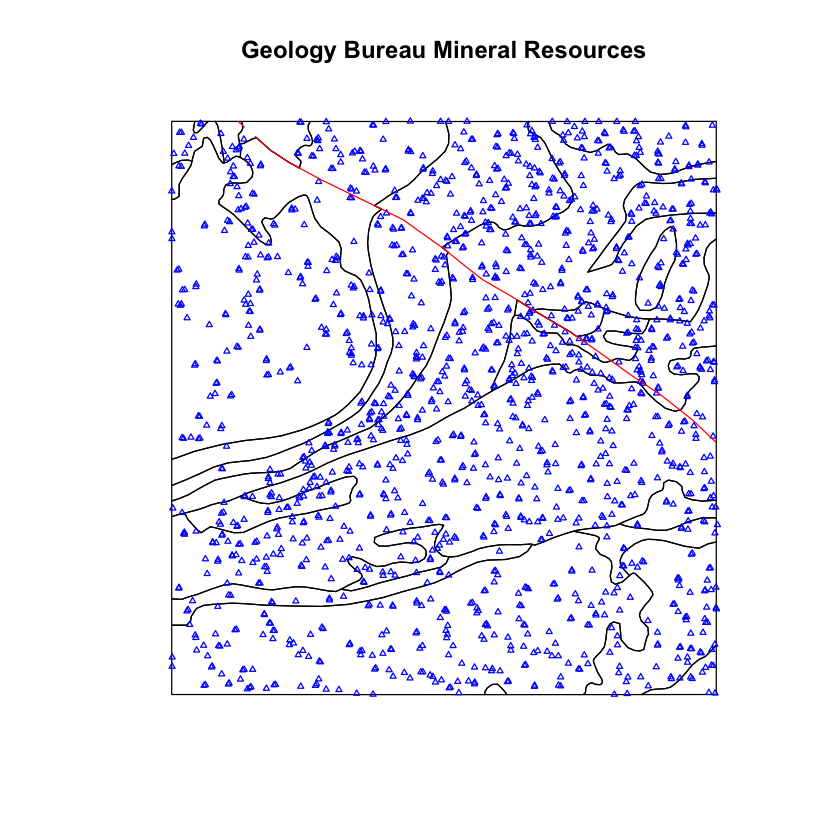

In [11]:
#13-04
# Plot the results
par(mfrow=c(1, 1))
plot(geo_bmrgg$geometry, main = "Geology Bureau Mineral Resources")
plot(bmrgg_sf$geometry, pch = 2, cex = 0.5, col = "blue", add = TRUE)
plot(flt_bmrgg$geometry, cex = 3, col = "red", add = TRUE)

<span style="color:green;"> 
    <h2> 13.2 Preparing the maps </h2>
</span>

In [12]:
#13-05
# Verify the symbols
sort(unique(geo_bmrgg$SYMBOL))

[1] "g5"  "K"   "L6"  "L7"  "L8"  "L9"  "M10" "M6"  "M6b" "Y4"  "Y5"

In [13]:
#13-06
# Create the color codiing
murphy_colors = c(
    rgb(233,31,55, maxColorValue = 255), # g5 Nicholson Granite Complex
    rgb(232,237,209, maxColorValue = 255), # K Carpentaria Basin
    rgb(213,176,166, maxColorValue = 255), # L6 Wire Creek Sandstone
    rgb(122,179,218, maxColorValue = 255), # L7 Fickling Group
    rgb(195,233,249, maxColorValue = 255), # L8 Doomadgee Formation
    rgb(226,207,194, maxColorValue = 255), # L9 South Nicholson Group
    rgb(226,227,228, maxColorValue = 255), # M10 Bukalara Sandstone, Wessel Group
    rgb(213,176,166, maxColorValue = 255), # M6 Parsons Range, Tawallah, and Katherine River Groups
    rgb(53,189,166, maxColorValue = 255), # M6b Seigal Volcanics
    rgb(221,154,97, maxColorValue = 255), # Y4 Murphy Metamorphics
    rgb(255,237,114, maxColorValue = 255) # Y5 Cliffdale Volcanics
)

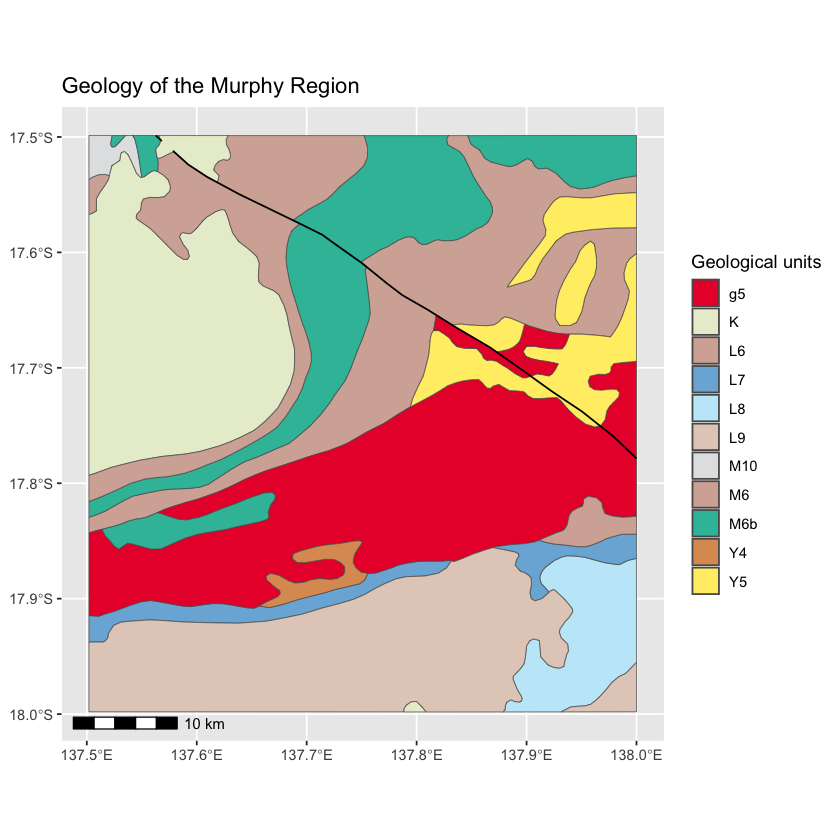

In [14]:
#13-07
# In ggplot() use ‘sf’ variables with the geom_sf() function
ggplot(data = geo_bmrgg) +
    geom_sf(aes(fill = geo_bmrgg$SYMBOL)) +
    scale_fill_manual(values = murphy_colors, name="Geological units") +
    geom_sf(data = flt_bmrgg, color = "black") +
    # Add a scale bar in km
    annotation_scale(location = "bl", width_hint = 0.25, text_cex = 0.75) +
    # Add a title to the plot
    labs(title = "Geology of the Murphy Region")

In [15]:
#13-08/01
# Set colours manually
pal = colorFactor(
    palette = murphy_colors,
    levels = sort(unique(geo_bmrgg$SYMBOL)),
    alpha = T, 
    ordered = TRUE)

# Verify the color scheme
previewColors(pal(sort(unique(geo_bmrgg$SYMBOL))),
sort(unique(geo_bmrgg$SYMBOL)))

Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


,g5
,K
,L6
,L7
,L8
,L9
,M10
,M6
,M6b
,Y4
,Y5


In [16]:
#13-08/02
# Define the icon for the stream sediment samples
ss_icon_url = "https://wiki.openstreetmap.org/w/images/thumb/e/e3/Volcano-8.svg/8px-Volcano-8.svg.png"

# Create Leaflet map of Murphy geology
leaflet() %>%
    addProviderTiles("Esri.WorldImagery", group = "Satellite") %>% # satellite map
    addTiles(group = "Topographic") %>% # Base map
    addMarkers(data= bmrgg_sf,
               icon = makeIcon(ss_icon_url, iconWidth = 5, iconHeight = 5), # icon for the samples
    group = "Stream sediments", # for control
    popup = ~SAMPLEID) %>% # for naming the samples
    addPolygons(data=geo_bmrgg,
                group="Geology", # for control
                fillColor = ~pal(SYMBOL), 
                fillOpacity = 0.7, # fill colour and opacity
                color="black", 
                weight = 1, # boundary color and width
    popup = ~paste(geo_bmrgg$SYMBOL,"<br>",geo_bmrgg$STRAT_UNIT))%>% # For geological units
    addPolylines(data=flt_bmrgg,
                 group="Faults",
                 color = "black", 
                 weight = 2 ) %>%
    addLegend(position = "bottomright",
              group ="Legend",
              colors = pal(sort(unique(geo_bmrgg$SYMBOL))),
              labels = sort(unique(geo_bmrgg$SYMBOL)),
              title = "Symbols") %>%
    addScaleBar(position = "bottomleft",
                options = scaleBarOptions(imperial = FALSE)) %>%
    addLayersControl(overlayGroups = c("Topographic","Satellite","Stream sediments","Geology","Faults","Legend"))

HTML widgets cannot be represented in plain text (need html)

<span style="color:green;"> 
    <h2> 13.3 Subsetting the stream sediments </h2>
</span>

In [17]:
#13-09/01
# Verify the Lithology
unique(bmrgg_sf$LITHOLOGY)

[1] ""

In [18]:
#13-09/02
# Identify the points that intersect with polygons
bmrgg_sf_join = st_join(bmrgg_sf, geo_bmrgg["SYMBOL"], join = st_within, left = TRUE)

# How many samples per SYMBOL
count(group_by(as.data.frame(bmrgg_sf_join), SYMBOL))

SYMBOL,n
<chr>,<int>
K,129
L6,10
L7,26
L8,64
L9,203
M10,6
M6,319
M6b,265
Y4,17


In [19]:
#13-09/03
# Identify the points that intersect with polygons
bmrgg_sf_join = st_join(bmrgg_sf, geo_bmrgg["SYMBOL"], 
                        join = st_nearest_feature, left = TRUE)

# How many samples per SYMBOL
count(group_by(as.data.frame(bmrgg_sf_join), SYMBOL))

SYMBOL,n
<chr>,<int>
K,129
L6,10
L7,27
L8,65
L9,203
M10,6
M6,321
M6b,266
Y4,17


In [ ]:
#13-10/01
# Create a data frame with symbol and description
geo_description = as.data.frame(
    cbind( 
        name = c("g5", "K", "L6", "L7", "L8", "L9", "M10", "M6","M6b", "Y4", "Y5"),
        description = c("Nicholson Granite Complex","Carpentaria Basin","Wire Creek Sandstone", "Fickling Group","Doomadgee Formation","South
Nicholson Group", "Bukalara Sandstone, Wessel Group", "Parsons Range, Tawallah, and Katherine River Groups", "Seigal Volcanics","Murphy
Metamorphics","Cliffdale Volcanics") ))

In [ ]:
#13-10/02
# Merge the geological description to complete the geology data frame
bmrgg_sf_merged = merge(x = bmrgg_sf_join, y = geo_description, 
                        by.x = "SYMBOL", by.y = "name")

In [ ]:
#13-10/03
# Retrieve 10 samples of the merged dataset
set.seed(123)
bmrgg_sf_merged[sample(1:nrow(bmrgg_sf_merged), 10),c("SAMPLEID", "description")]

In [ ]:
#13-10/04
# Count the results
count(group_by(as.data.frame(bmrgg_sf_merged), description))

<span style="color:green;"> 
    <h2> 13.4 Group statistics </h2>
</span>

In [ ]:
#13-11
# Load the library
library(psych)

# Identify the variables present
names(bmrgg_sf_merged)

# Subset to geological symbol and chemical analysis
df = as.data.frame(bmrgg_sf_merged[,c(1,20:37)])

# Describe the data
describeBy(df[,2:19],df$SYMBOL)

In [ ]:
#13-12/01
# Load the library
library(corrgram)

# Only the geochemical data and the SYMBOL
data = as.data.frame( st_drop_geometry( bmrgg_sf_merged[,c(20:28, 30:37,1)] ))

# Convert negatives to NAs
data[data < 0] = NA

In [ ]:
#13-12/02
options(warn=-1)
# Cycle all the geological units, sorted
for(var in sort(unique(data$SYMBOL))) {
    # Select a subset that has the geological unit
    df = data[data$SYMBOL == var, ]
    # Remove columns that have NA
    df = df[, colSums(is.na(df)) == 0 ]
    # The corrgram
    corrgram(df, 
             upper.panel=panel.cor,
             main=paste("Correlation for", var, "geological Unit \n for",ncol(df)-1,"variables and", nrow(df),"rows"),
            order=T)
}
options(warn=0)

In [ ]:
#13-13/01
# Define the working variables
data = as.data.frame( st_drop_geometry( bmrgg_sf_merged[,c(20:37, 1)]))

# Empty list for storing the results
results = list()

# Cycle all the chemical analysis
for (var in names(data[, 1:18])) {
    # Create the formula to be used in the aov() analysis
    formula = as.formula(paste(var, "~ SYMBOL"))
    model = aov(formula, data = data)
    # Retrieve the p_value
    p_value = summary(model)[[1]][["Pr(>F)"]][[1]]
    # Create a list of p_values
    results[[var]] = p_value
    # Print the results
    if (!is.na(p_value)) {
        if (p_value < 0.05) {
        print(paste(var, "is dependent on geological unit (p-value =",
        format(p_value, scientific = TRUE, digits = 3), ")"))
        } else {
        print(paste(var, "is independent of geological unit (p-value =",
        format(p_value, scientific = TRUE, digits = 3), ")"))
        }
        } else {
        print(paste(var, "is not usable"))
        }
}

In [ ]:
#13-13/02
# Convert the list to a data frame
results_bmrgg = data.frame(variable = names(results), p_value = unlist(results))

# Sort the data frame by ascending p-value
results_bmrgg = arrange(results_bmrgg, p_value)

# Print the top and bottom 3 dependent variables
print("Top 3 dependent variables:")
print(head(results_bmrgg, 3))
print("Top 3 independent variables:")
print(tail(results_bmrgg, 3))

In [ ]:
#13-14/01
# Load the library
library(gridExtra)
library(grid)

# The top and bottom 3
vars = c(head(results_bmrgg, 3)$variable, tail(results_bmrgg, 3)$variable)

In [ ]:
#13-14/02
# Create a empty list of plots
plots = list()

# Create a boxplot for the most dependent variable for each symbol
for(i in 1:length(vars)) {
    # Data frame for each geological unit
    plot_data = data.frame(x = data$SYMBOL, y = data[,vars[i]])
    var_name = vars[i]
    # Create the plot
    p = ggplot(plot_data, aes(x = x, y = y, fill=x)) +
        geom_boxplot() +
        scale_fill_manual(values = murphy_colors) +
        guides(fill = "none")+
        labs(x = "Geo Unit", y = var_name) +
        ggtitle(paste(var_name , "by Geological Unit"))
    # Add the plot to the list of plots
    plots[[i]] = p
}

In [ ]:
#13-14/03
# Arrange the plots in two rows
# First column of plots (dependent variables)
left_col_plots = list(plots[[1]], plots[[2]], plots[[3]])

# Second column of plots (independent variables)
right_col_plots = list(plots[[4]], plots[[5]], plots[[6]])

# Title text for both columns
t1 = textGrob("Dependent", gp = gpar(fontsize = 14, fontface = "bold"))
t2 = textGrob("Independent", gp = gpar(fontsize = 14, fontface = "bold"))

# Arrange the plots in a grid
grid.arrange(
    arrangeGrob(
        arrangeGrob(grobs = left_col_plots, ncol = 1, top = t1),
        arrangeGrob(grobs = right_col_plots, ncol = 1, top = t2),
        ncol = 2, widths = c(1, 1)
    )
)

<span style="color:green;"> 
    <h2> 13.5 This is not my fault </h2>
</span>

In [ ]:
#13-15/01
# Create the buffer. Use ‘sf’ for ease of calculating the buffer
buf_flt_sf = st_buffer(flt_bmrgg, 1000)

# Merge the polygons created
buf_flt_sf = st_union(buf_flt_sf)

# Create a new ‘sf’ object with the merged geometry
buf_flt_sf = st_sf(geometry = buf_flt_sf)

In [ ]:
#13-15/02
# Subset the samples inside and outside the buffer
bmrgg_sf_inside = st_intersection(bmrgg_sf_merged, buf_flt_sf)
bmrgg_sf_outside = st_difference(bmrgg_sf_merged, buf_flt_sf)

In [ ]:
#13-15/03
# Verify the result
leaflet() %>%
    addTiles(group = "Topographic") %>% # Base map
    addMarkers(data= bmrgg_sf_inside,
        icon = makeIcon(ss_icon_url, iconWidth = 8, iconHeight = 8),    # icon
        group = "Inside",
        popup = ~ SAMPLEID) %>% # for naming the samples
    addMarkers(data= bmrgg_sf_outside,
        icon = makeIcon(ss_icon_url, iconWidth = 5, iconHeight = 5),         # icon
        group = "Outside",
        popup = ~ SAMPLEID) %>% # for naming the samples
    addPolygons(data=geo_bmrgg,
        group="Geology", # for control
        fillColor = ~pal(SYMBOL), fillOpacity = .7, # color and     opacity
        color="black", weight = 1, # boundary color and width
        popup = ~paste(geo_bmrgg$SYMBOL,"<br>",geo_bmrgg$GEOLREGION,
        "<br>", geo_bmrgg$description)) %>% # For geological units
    addPolygons(data=buf_flt_sf,
        group="Buffer", # for control
        fillColor = "grey", fillOpacity = .7, # fill color and opacity
        color="grey", weight = 1) %>% # color and width Buffer Fault
        addPolylines(data=flt_bmrgg,
        group="Faults",
        color = "black", weight = 2 ) %>%
    addLegend(position = "bottomright",
        group ="Legend",
        colors = pal(sort(unique(geo_bmrgg$SYMBOL))),
        labels = sort(unique(geo_bmrgg$SYMBOL)),
        title = "Symbols") %>%
    addScaleBar(position = "bottomleft",
        options = scaleBarOptions(imperial=FALSE)) %>%
        addLayersControl( overlayGroups = c("Topographic","Buffer","Inside","Outside", "Geology","Faults","Legend"))

In [ ]:
#13-16/01
# Intermediate variables
df_inside = as.data.frame(bmrgg_sf_inside)
df_outside = as.data.frame(bmrgg_sf_outside)

# Remove columns that have NA
bmrgg_sf_inside_clean = df_inside[ ,colSums(is.na(df_inside)) == 0 ]
bmrgg_sf_outside_clean = df_outside[ ,colSums(is.na(df_outside)) == 0 ]

# Verify the cleaned data
names(bmrgg_sf_inside_clean)
names(bmrgg_sf_outside_clean)

In [ ]:
#13-16/02
# The elements Cr [25] and Mn [28] are missing in the bmrgg_sf_outside_clean dataset
# Subset the two dataframes with the same variables
df_inside_chem = bmrgg_sf_inside_clean[ ,c(20:24,26,27,29:37)]
df_outside_chem = bmrgg_sf_outside_clean[ ,c(20:35)]

In [ ]:
#13-16/03
# Create an empty data frame
results = data.frame(element = character(0), p_value = numeric(0))
# Calculate the Wilcox test for all the chemical elements
for( i in names(df_inside_chem)) {
    results_wilcox = wilcox.test(as.numeric(df_inside_chem[[i]]),
    as.numeric(df_outside_chem[[i]]))
    # Print the result from the Wilcox test
    print(paste0(i," p value: ", round(results_wilcox$p.value, 3)))
    # Save a variable with the results
    new_data = data.frame(element = i, p_value = results_wilcox$p.value)
    results = rbind(results, new_data)
}

In [ ]:
#13-16/04
# Load the library
library(dplyr)

# Variables with significant Wilcoxon rank-sum test
print(paste("Dependent variables"))
filter(results, p_value < 0.05)

# Variables with significant Wilcoxon rank-sum test
print(paste("Independent variables"))
filter(results, p_value >= 0.05)

<span style="color:blue;"> 
    <h1> References </h1>
</span>

Nothing to refer...